Load required libraries first

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

# We are disabling this function because this magic function exist only in Google Colab, not in 
# Jupyter Notebook
# %tensorflow_version 1.x


import tensorflow as tf
from tensorflow.python.data import Dataset

# Original Codelab code had this line, but it is not compatible with TensorFlow 2
# tf.logging.set_verbosity(tf.logging.ERROR)
# Replaced with below
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [8]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

Now we will randomize the data to ensure that we are not getting any pathological ordering effects which can harm **Stohastic Gradient Descent**

We will also scale `median_house_value` to be in units of thousands, so it can be learned a little more easily when learning rates in a range that we really use.

In [ ]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

# Examine the data

It is good idea to get to know your data a little bit before you work with it. 

Lets print out a quick sunmmary of a few useful statistics on eahc column: count of examples, mean, standard deviation, max, min and various quantiles.


In [10]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


# Build the first model

We will try to build the first model. We will try to predict `median_house_value`, which is going to be our *label* (or sometimes called target). We'll use `total_rooms` as out input feature. So we will try to build a linear regressions from *total rooms to the median_house_value*.

**NOTE:** data is at the city block level, so this feature represents the total number of rooms in that block.

We will use LinearRegressor of tensorflow Estimator API. This API takes care of the low level model plumbing, and exposes convenient methods for performing model training, evaluation and inference.



## Step1: Define features and Configure Feature Columns

There are two main types of data:

 * **Categorical Data**: data that it textual. Here we do not have any.
 * **Numerical Data**: Data that is a number (integer or float) and that *you want to treat as a number*
 
In TensorFlow, the feature's data type is indicated using construct called **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself. 

Lets define one numeric input feature, `total_rooms`

In [40]:
# There was this line in the manual but I am not sure what it means. So comment this out for now
# my_feature = california_housing_dataframe[["total_rooms"]]

# Ok, the syntax of [[]] is pandas is to get back a new dataframe which is subsection of the original one
# you specify the name of columns which you want in your new dataframe
my_feature = california_housing_dataframe[["total_rooms"]]

feature_columns = [tf.feature_column.numeric_column("total_rooms")]

## Step 2: Define a target

Here we will define our target, `median_house_value`. It is defined on the dataframe

In [21]:
targets = california_housing_dataframe["median_house_value"]
targets

11246   220.1
14887   130.7
2406    164.3
901     124.7
12052    88.6
         ... 
14544   500.0
3190    297.2
16055   500.0
16326   268.1
16763   148.8
Name: median_house_value, Length: 17000, dtype: float64

## Step 3: Configure the LinearRegressor

We will train model using `GradientDescentOptmizier` which implements Mini-Batch Stochastic Gradient Descent (SGD). As usual, `learning_rate` controls the size of gradient step.

**NOTE:** we also apply *gradient clipping* to our optimizer via `clip_gradient_by_norm`. This ensure magnitude of gradients do not become too large.

In [113]:
# This code was modified from the following example: 
#
# my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
# my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
#
# # Configure the linear regression model with our feature columns and optimizer.
# # Set a learning rate of 0.0000001 for Gradient Descent.
# linear_regressor = tf.estimator.LinearRegressor(
#    feature_columns=feature_columns,
#    optimizer=my_optimizer
# )
# To work with TensorFlow 2


from tensorflow.keras import optimizers
my_optimizer = optimizers.SGD(lr=0.01, clipvalue=0.5)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

## Step 4: Define an input function

We need to define an input function. Lets check what is input function for TensorFlow

In [136]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature
    
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Wheter to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. none = repeat indefinitely.
      
    Returns:
      Tupe of (features, labels) for next data batch
    """
    
    # The line below does the following
    # dict(features) - this converts the DataFrame to key:value dict:
    # {total_rooms: series(values)}
    # The value is Pandas Seres
    # 
    # Then items, does key->value iteration
    # There going to be one record, so the new dict is created where
    # key is the title of series (total_rooms)
    # value is converted to array series
    # So all this line does is conver the dataframe of feature to key:array(value) dict for features
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Now when we have features in the correct format, we construct dataset
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Step 5: Train the model

Now we can call `train()` on `linear_regressor` to train the model.


In [115]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

My input fn called


## Step 6: Evaluate the model

We will look how perdiction works. 

**Note:** this is done on training data only, so we can not gauge how good generalization of it.

In [116]:
# Create input function for prediction. We can reuse the one to train.

prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

predictions = linear_regressor.predict(input_fn=prediction_input_fn)

In [117]:

# Here we transform result. For each line in dataset we get back a dict where
# key is predictions and value is an array of predictions
# Since we had only 1 target value, we take the 0 one
predictions = np.array([item['predictions'][0] for item in predictions])

My input fn called


In [118]:
# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 57614.700
Root Mean Squared Error (on training data): 240.031


The question is - how good this error is?

MSE is hard to interpret. Root Mean Square Error can be used at the same scale as target. 

Here we compare the RMSE to the difference between min & max of targets:

In [119]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 240.031


The error spans around half of the range of our target value. Can we do better?

Lets see how well predictions match our targets. Some overal statistics:

In [120]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()


,predictions,targets
count,17000.0,17000.0
mean,264.5,207.3
std,218.0,116.0
min,0.3,15.0
25%,146.3,119.4
50%,212.8,180.4
75%,315.2,265.0
max,3793.8,500.0


The guide here says to answer following:

How does mean value compare to the models' RMSE?

Mean value: 207 (target), 211(prediction), RMSE: 196. Answer: they are "close-ish?"

Now lets build the graph to see whats going on. 

Start with uniform random sample data.

In [121]:
sample = california_housing_dataframe.sample(n=300)

Plot

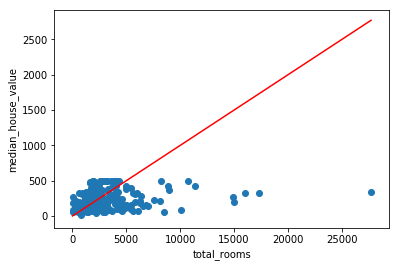

In [122]:
# Define boundaries of graph 

x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# This just hooking into getting the active values of  y = w1x1 + b
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Here we draw the line of model using these valeus

y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot regression line
plt.plot([x_0, x_1], [y_0, y_1], c='r')
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

plt.scatter(sample["total_rooms"], sample["median_house_value"])

plt.show()

Question from the manual: Can you see the fact that the model is bad from overview analytics. Potential answer: perhaps because the maximum value was so off for the model in the range? 

Now we create the code which iteratively trains model and show the progress on a graph:

In [129]:
from functools import partial


def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  # the partial trick is a workaround to https://github.com/tensorflow/tensorflow/issues/33358
  my_optimizer = partial(optimizers.SGD, lr=learning_rate, clipvalue=0.5)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
My input fn called
My input fn called
  period 00 : 219.92
My input fn called
My input fn called
  period 01 : 204.03
My input fn called
My input fn called
  period 02 : 190.29
My input fn called
My input fn called
  period 03 : 179.21
My input fn called
My input fn called
  period 04 : 171.54
My input fn called
My input fn called
  period 05 : 167.68
My input fn called
My input fn called
  period 06 : 166.34
My input fn called
My input fn called
  period 07 : 166.30
My input fn called
My input fn called
  period 08 : 166.29
My input fn called
My input fn called
  period 09 : 166.39
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,135.7,207.3
std,111.8,116.0
min,0.2,15.0
25%,75.1,119.4
50%,109.2,180.4
75%,161.7,265.0
max,1946.2,500.0


Final RMSE (on training data): 166.39


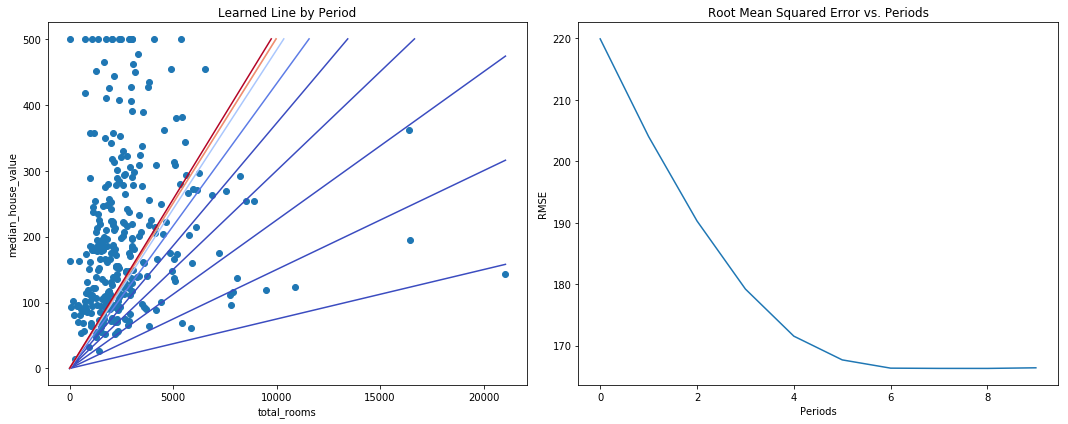

In [134]:
train_model(
    learning_rate=0.0003,
    steps=500,
    batch_size=100
)

Training model...
RMSE (on training data):
  period 00 : 225.62
  period 01 : 214.63
  period 02 : 204.80
  period 03 : 196.46
  period 04 : 189.71
  period 05 : 184.32
  period 06 : 180.47
  period 07 : 178.12
  period 08 : 176.65
  period 09 : 176.01
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,118.9,207.3
std,95.4,116.0
min,0.3,15.0
25%,65.8,119.4
50%,97.1,180.4
75%,143.1,265.0
max,2965.8,500.0


Final RMSE (on training data): 176.01


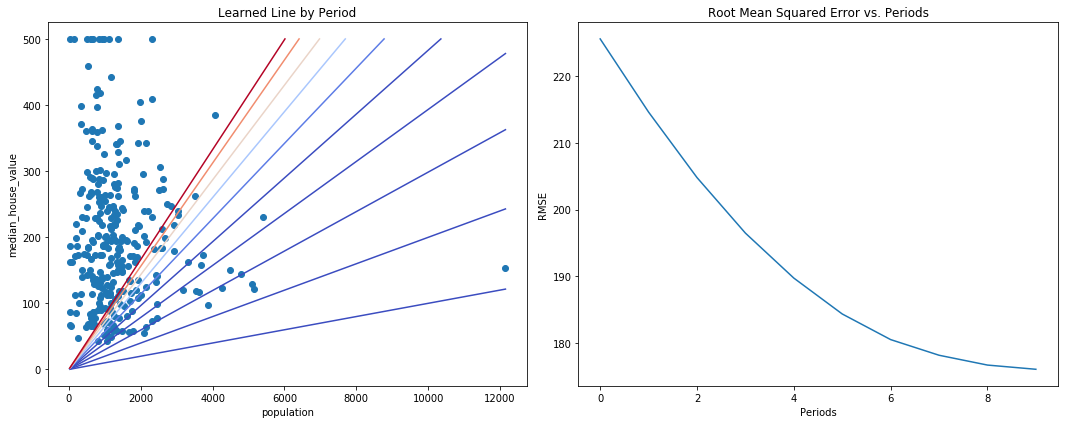

In [138]:
train_model(
    learning_rate=0.00002,
    steps=10000,
    batch_size=5,
    input_feature='population'
)